# Episode 64. SHAP - Boston Housing Prices

In [1]:
## Data: Boston Housing Prices
### Keras Built-in function - https://keras.io/api/datasets/boston_housing/
### Excel file form Kaggle - https://www.kaggle.com/fedesoriano/the-boston-houseprice-data

'''Original Data - http://lib.stat.cmu.edu/datasets/boston

The Boston house-price data of Harrison, D. and Rubinfeld, D.L. 'Hedonic
prices and the demand for clean air', J. Environ. Economics & Management,
vol.5, 81-102, 1978.

There are 14 attributes in each case of the dataset. They are:

CRIM - per capita crime rate by town
ZN - proportion of residential land zoned for lots over 25,000 sq.ft.
INDUS - proportion of non-retail business acres per town.
CHAS - Charles River dummy variable (1 if tract bounds river; 0 otherwise)
NOX - nitric oxides concentration (parts per 10 million)
RM - average number of rooms per dwelling
AGE - proportion of owner-occupied units built prior to 1940
DIS - weighted distances to five Boston employment centres
RAD - index of accessibility to radial highways
TAX - full-value property-tax rate per USD 10,000
PTRATIO - pupil-teacher ratio by town
B - 1000*(Bk - 0.63)^2 where Bk is the proportion of blacks by town
LSTAT - % lower status of the population
MEDV - Median value of owner-occupied homes in $1000's
'''

"Original Data - http://lib.stat.cmu.edu/datasets/boston\n\nThe Boston house-price data of Harrison, D. and Rubinfeld, D.L. 'Hedonic\nprices and the demand for clean air', J. Environ. Economics & Management,\nvol.5, 81-102, 1978.\n\nThere are 14 attributes in each case of the dataset. They are:\n\nCRIM - per capita crime rate by town\nZN - proportion of residential land zoned for lots over 25,000 sq.ft.\nINDUS - proportion of non-retail business acres per town.\nCHAS - Charles River dummy variable (1 if tract bounds river; 0 otherwise)\nNOX - nitric oxides concentration (parts per 10 million)\nRM - average number of rooms per dwelling\nAGE - proportion of owner-occupied units built prior to 1940\nDIS - weighted distances to five Boston employment centres\nRAD - index of accessibility to radial highways\nTAX - full-value property-tax rate per USD 10,000\nPTRATIO - pupil-teacher ratio by town\nB - 1000*(Bk - 0.63)^2 where Bk is the proportion of blacks by town\nLSTAT - % lower status of 

## Install Explainable AI Pachages (lime, shap, pdpbox)

In [2]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=b62c690eec04a3c8dc982f10933d0712726a4397c75951ccb10a69a824f6d684
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [3]:
!pip install -q shap # Run this if you do not have shap installed
import shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 3.9 MB/s eta 0:00:00


In [4]:
!pip install eli5 pdpbox category_encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.2/216.2 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.8/35.8 MB 38.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 61.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.1/121.1 kB 16.7 MB/s eta 0:00:00
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107720 sha256=1f437c1b334cba581192c0c053f774020a6e45caecff590b4dfda96d972dbb40
  Stored in directory: /root/.cache/pip/wheels/b8/58/ef/2cf4c306898c2338d51540e0922c8e0d6028e07007085c0004
Successfully built eli5


## Import Libraries

In [5]:
#imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

import xgboost as xgb
from xgboost import plot_importance
from sklearn.metrics import accuracy_score,confusion_matrix

import shap
shap.initjs()

## Load Data

In [6]:
# Load Boston Housing Price Data
# Original Data Source: https://www.kaggle.com/fedesoriano/the-boston-houseprice-data
from google.colab import files
uploaded = files.upload()

Saving boston.csv to boston.csv


In [7]:
# Store data in DataFrame
df = pd.read_csv("boston.csv")

## Set Training Variables

In [8]:
RANDOM_SEED = 27
# split data
X_train, X_test = train_test_split(df, test_size=0.2, random_state=RANDOM_SEED)
y_train = X_train['MEDV']
X_train = X_train.drop(['MEDV'], axis=1)
y_test = X_test['MEDV']
X_test = X_test.drop(['MEDV'], axis=1)

features = X_train.columns
print(features)

# Standardize data based on mean & sd of X_train
mean = X_train.mean(axis=0)
std = X_train.std(axis=0)
X_train = (X_train - mean) / std
X_test = (X_test - mean) / std

# convert to numpy
X_train = X_train.to_numpy()
y_train = y_train.to_numpy()
X_test = X_test.to_numpy()
y_test = y_test.to_numpy()

Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT'],
      dtype='object')


## Setup Neural Network

In [9]:
# Network Parameters
nn_in = X_train.shape[1]


In [10]:
def network(nn_in):
  model = Sequential()
  model.add(Dense(10, input_dim=nn_in, activation='relu'))
  model.add(Dense(1, activation='linear'))
  # compile model
  model.compile(loss='mse', optimizer='adam', metrics=['mae'])
  return model

In [11]:
model = network(nn_in)

In [12]:
model.fit(X_train, y_train, epochs=100, verbose=0)

In [13]:
_, accuracy = model.evaluate(X_test, y_test)
print(accuracy)

4/4 [==============================] - 0s 2ms/step - loss: 116.2380 - mae: 7.6319
7.631894588470459


In [14]:
y_pred = model.predict(X_test)

4/4 [==============================] - 0s 2ms/step


Text(0.5, 0, 'Actual')

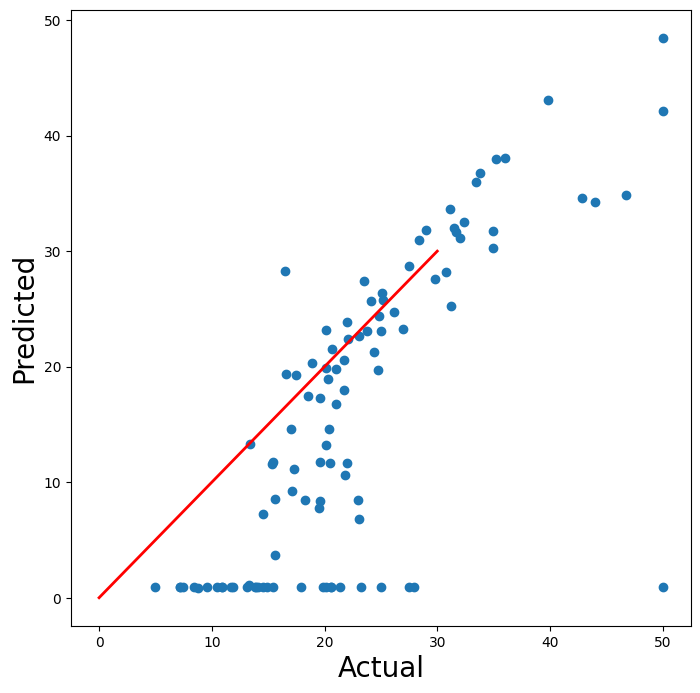

In [15]:
#Model evaluation
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(8,8))

plt.scatter(y_test,y_pred)
plt.plot([0, 30], [0, 30], color='r', linestyle='-', linewidth=2)

plt.ylabel('Predicted',size=20)
plt.xlabel('Actual',size=20)

## SHAP

Now that we have our model we can calculate our SHAP values. To do this, we pass our model into the SHAP Explainer function to create an **explainer object**. We then use this to **calculate the SHAP values for every observation in the feature matrix**. For every observation, we will have 13 SHAP values. That is one SHAP value for each feature in our model.


In [85]:
# select backgroud for shap
background = X_train[np.random.choice(X_train.shape[0], 100, replace=False)]

In [ ]:
# Get shap values
#explainer = shap.KernelExplainer(model.predict,X_train)
explainer = shap.KernelExplainer(model.predict, background)
# Compute SHAP values for the test set. This step can be time-consuming for large datasets.
shap_values = explainer.shap_values(X_test, nsamples = 100)

In [87]:
print(np.array(shap_values).shape)
print(X_test.shape)
# For each observation, 13 SHAP values
print(shap_values[0][0])

(102, 13, 1)
(102, 13)
[-4.68890909]


In [88]:
shap_values = np.array(shap_values).reshape((102,13))
shap_values.shape

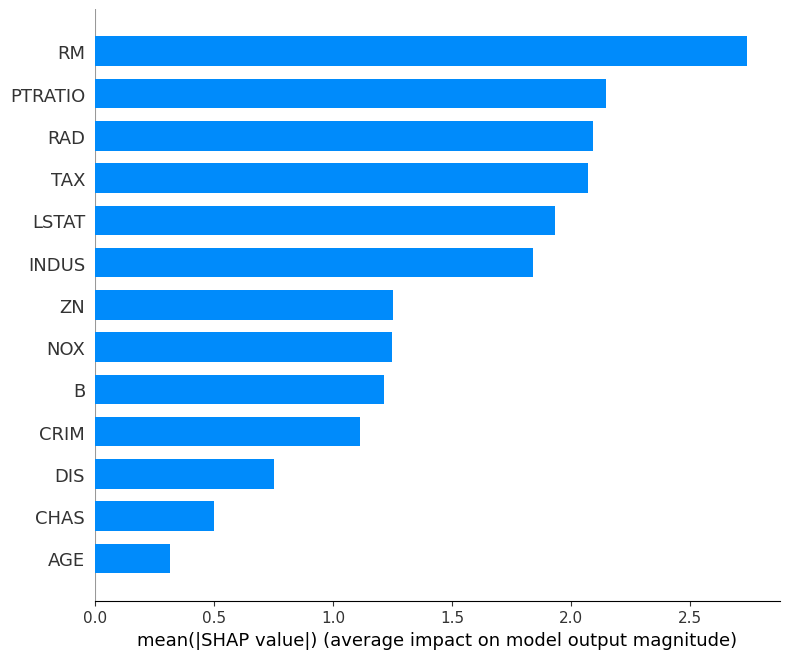

In [90]:
# Summary Plot
#shap.summary_plot(shap_values[0,0:13], plot_type = 'bar', feature_names = features)
shap.summary_plot(shap_values2, X_test, plot_type='bar', feature_names=features)

In [ ]:
import numpy as np
import shap

# Select a background sample from your training data for more efficient computation.
background = X_train[np.random.choice(X_train.shape[0], 100, replace=False)]

# Initialize the KernelExplainer with your model's prediction function and the background sample.
explainer = shap.KernelExplainer(model.predict, background)

# Compute SHAP values for the test set. This step can be time-consuming for large datasets.
shap_values = explainer.shap_values(X_test, nsamples=100)

# It's good to understand the shape of the SHAP values array
print(np.array(shap_values).shape)  # Expecting (number_of_outputs, number_of_samples, number_of_features)
print(X_test.shape)

# Display SHAP values for the first test sample's prediction (as an example)
print(shap_values[0][0])

# Summary plot for SHAP values to understand the impact of each feature across a

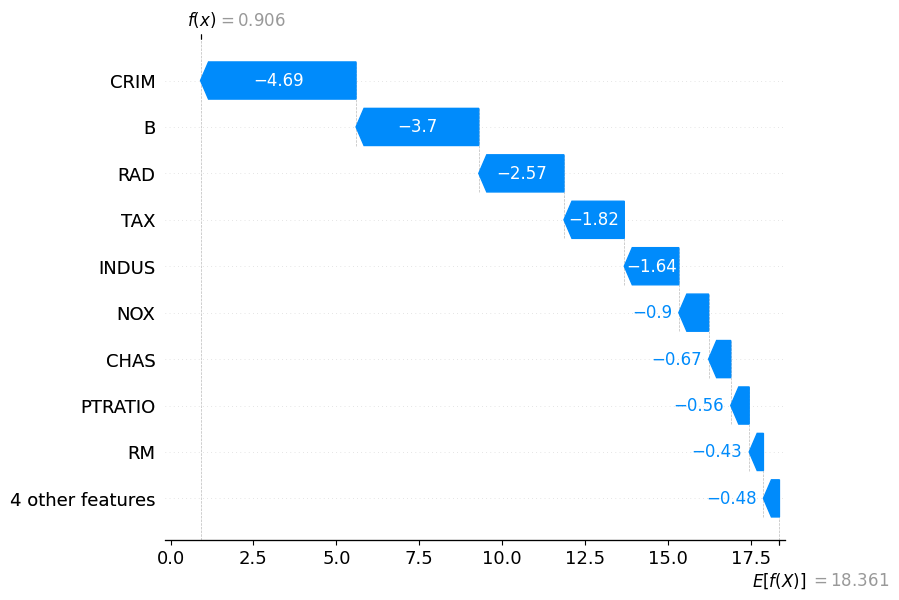

In [95]:
# Waterfall Plot
shap.initjs()
shap.plots._waterfall.waterfall_legacy(explainer.expected_value[0], shap_values[0], feature_names = features)


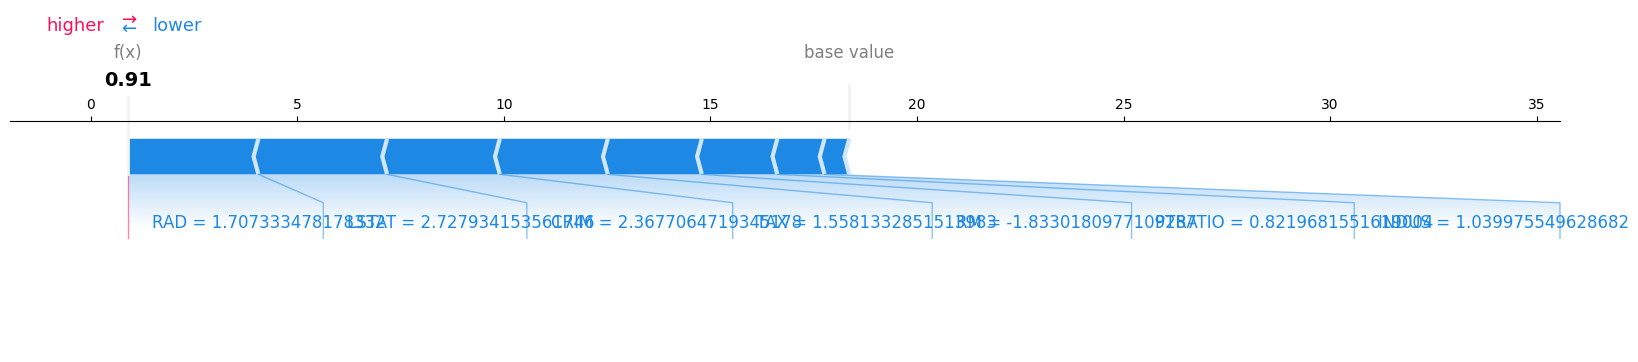

In [98]:
# Force Plot for a single prediction
shap.initjs()  # Initialize JavaScript visualization in Jupyter notebook

# Assuming `features` is a list of feature names corresponding to the columns in `X_test`
# If not, you will need to define this list of feature names manually.
# For example: features = ['feature1', 'feature2', ..., 'featureN']

# Adjusting for numpy array access
instance_index = 5  # Adjust this index to the instance you're interested in
instance_features = X_test[instance_index]  # Accessing the instance from a numpy array

# Correcting the force plot call for a numpy array
shap.force_plot(
    explainer.expected_value,  # For single-output models, `expected_value` is typically a scalar
    shap_values[instance_index],  # SHAP values for the specific instance
    features=instance_features,  # Feature values for the instance as a numpy array
    feature_names=features,  # Assuming `features` is defined as a list of feature names
    matplotlib=True  # Set to False for interactive plot, True for static matplotlib plot
)

In [99]:
# Interactive force plot for multiple instances
# Let's visualize the first 10 instances as an example
shap.initjs()
multi_force_plot = shap.force_plot(
    explainer.expected_value,
    shap_values[:10],  # Adjust this slice for the instances you want to include
    features=X_test[:10],  # Corresponding feature values for the instances
    feature_names=features
)

# Display the plot
multi_force_plot

In [102]:
# Generate an interactive SHAP force plot
shap.initjs()
shap_plot = shap.force_plot(
    explainer.expected_value,
    shap_values[0],  # Assuming shap_values[0] corresponds to the correct instance without needing a secondary index
    features=X_test[0],  # Accessing the first instance for a numpy array
    feature_names=features,  # Assuming 'features' is a list of column names
)

# Save the interactive plot as an HTML file
shap.save_html('force_plot.html', shap_plot)